In [1]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
from sklearn.metrics import precision_score, recall_score, f1_score  # For evaluation metrics calculation

In [2]:
# Load the dataset
eval_df = pd.read_csv('data.csv')  # Assumes a CSV file named 'data.csv' is available in the working directory

In [3]:
# Define a function to calculate evaluation metrics
def calculate_metrics(df):
    # Calculate precision: True Positives / (True Positives + False Positives)
    precision = precision_score(df['true'], df['pred'])
    # Calculate recall: True Positives / (True Positives + False Negatives)
    recall = recall_score(df['true'], df['pred'])
    # Calculate F1 score: Harmonic mean of precision and recall
    f1 = f1_score(df['true'], df['pred'])
    return precision, recall, f1

In [4]:
# Compute metrics for the dataset
precision, recall, f1 = calculate_metrics(eval_df)  # Call the function with the loaded DataFrame
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")  # Output the results

,Email,Label
0,Are you safe from Duo?\n \nDid you learn enoug...,neutral informal
1,"GM Crypto Fam,\n \nBig things are happening in...",positive informal
2,"Welcome to dbdiagram.io, a free tool that help...",positive informal
3,"Hi there,\n\nI'm afraid I have some bad news —...",negative informal
4,New years provide new opportunities for growth...,positive informal


In [5]:
# Create a copy of the dataset
eval_df_with_pred = eval_df.copy()  # Makes a duplicate for safe modifications

# Save the modified DataFrame to a new CSV file
eval_df_with_pred.to_csv('eval_df_with_pred.csv')  # Outputs the DataFrame as 'eval_df_with_pred.csv'

In [11]:
from transformers import pipeline

sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", framework = 'pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [13]:
eval_df['sentiment'] = eval_df['Email'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
labels = {"LABEL_0": 'negative', "LABEL_1": 'neutral', "LABEL_2": 'positive'}
eval_df['sentiment'] = eval_df['sentiment'].map(labels)

In [16]:
!pip install groq
from groq import Groq

def detect_formality(text):
    api_key = os.getenv("GROQ_API_KEY")
    client = Groq(api_key=api_key)
    completion = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "user",
                "content": f"tell if this text is formal or not in one word '{text}'"
                },
            {
                "role": "assistant",
                }
            ],
        temperature=0.2,
        max_tokens=100,
        top_p=1,
        stream=True,
        stop=None,
        )
    res = ""
    for chunk in completion:
        res += chunk.choices[0].delta.content or ""
    return res

In [17]:
eval_df['formality'] = eval_df['Email'].apply(detect_formality)

In [18]:
eval_df['formality'].replace(['Formal.', 'Formal'], 'formal', inplace = True)
eval_df['formality'].replace(['Informal.', 'Informal'], 'informal', inplace = True)


<ipython-input-18-9055970ea2d4>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eval_df['formality'].replace(['Formal.', 'Formal'], 'formal', inplace = True)


In [20]:
eval_df['Analyzed_label_no_tuning'] = eval_df['sentiment']+" "+eval_df['formality']
eval_df.drop(['formality', 'sentiment'], axis = 1, inplace = True)

In [6]:
# Generate classification report as a dictionary
report_1 = classification_report(eval_df['Label'], eval_df['Analyzed_label'], output_dict=True)

# Convert to DataFrame
report_df_1 = pd.DataFrame(report_1).transpose()

# Print DataFrame to verify
print(report_df_1)

                   precision    recall  f1-score  support
negative formal     1.000000  0.500000  0.666667      2.0
negative informal   1.000000  0.600000  0.750000      5.0
neutral formal      0.800000  0.571429  0.666667      7.0
neutral informal    0.500000  1.000000  0.666667      3.0
positive formal     0.666667  1.000000  0.800000      4.0
positive informal   1.000000  1.000000  1.000000      9.0
accuracy            0.800000  0.800000  0.800000      0.8
macro avg           0.827778  0.778571  0.758333     30.0
weighted avg        0.858889  0.800000  0.798333     30.0


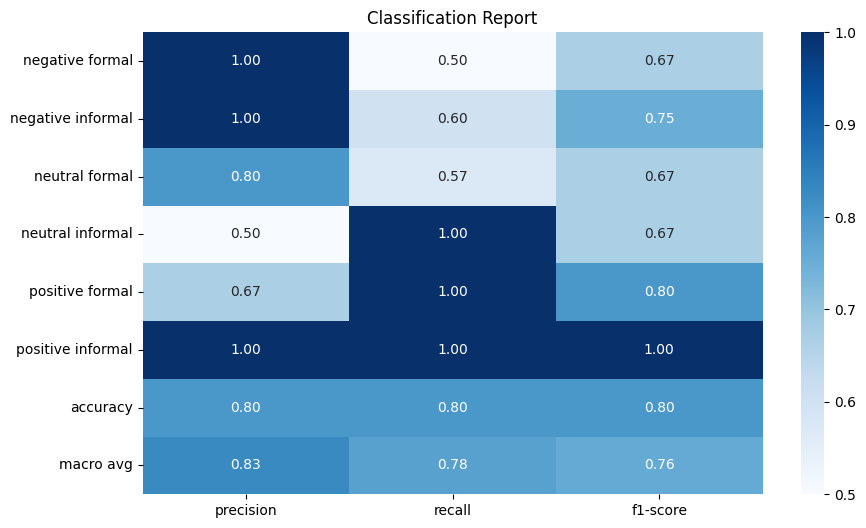

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(report_df_1.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report for Fine-Tune Model")
plt.show()

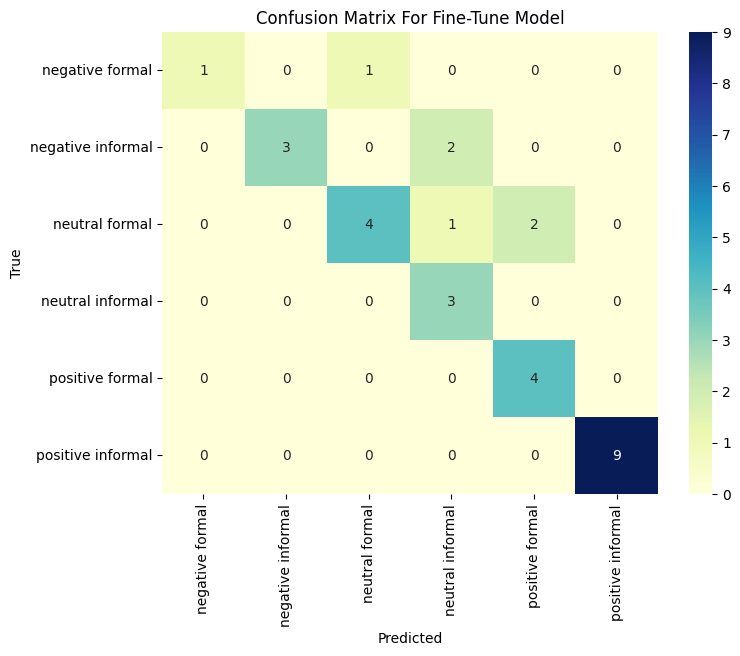

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(eval_df['Label'], eval_df['Analyzed_label'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=sorted(eval_df['Label'].unique()), yticklabels=sorted(eval_df['Label'].unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix For Fine-Tune Model")
plt.show()


In [21]:
# Generate classification report as a dictionary
report_2 = classification_report(eval_df['Label'], eval_df['Analyzed_label_no_tuning'], output_dict=True)

# Convert to DataFrame
report_df_2 = pd.DataFrame(report_2).transpose()

# Print DataFrame to verify
print(report_df_2)

                   precision    recall  f1-score    support
negative formal     0.666667  1.000000  0.800000   2.000000
negative informal   1.000000  1.000000  1.000000   5.000000
neutral formal      1.000000  0.142857  0.250000   7.000000
neutral informal    0.400000  0.666667  0.500000   3.000000
positive formal     0.571429  1.000000  0.727273   4.000000
positive informal   0.888889  0.888889  0.888889   9.000000
accuracy            0.733333  0.733333  0.733333   0.733333
macro avg           0.754497  0.783069  0.694360  30.000000
weighted avg        0.827302  0.733333  0.691970  30.000000


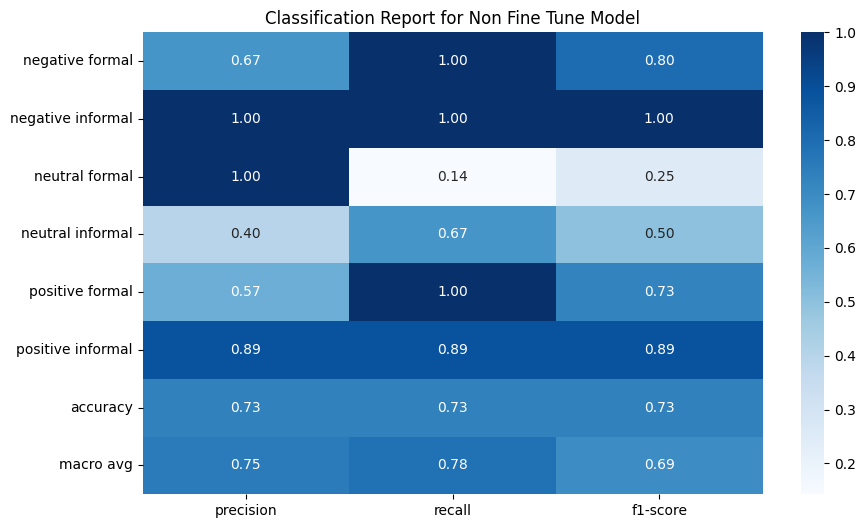

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(report_df_2.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report for Non Fine Tune Model")
plt.show()

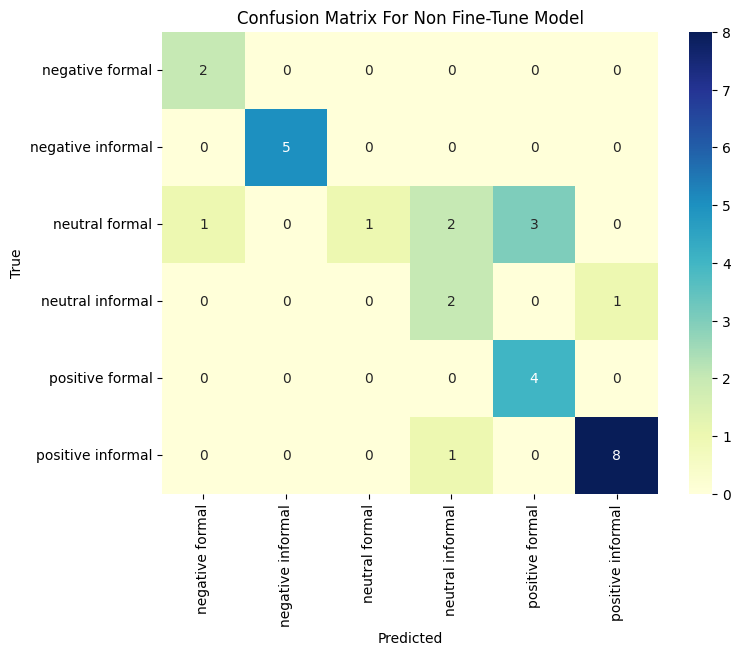

In [25]:
# Generate confusion matrix
cm = confusion_matrix(eval_df['Label'], eval_df['Analyzed_label_no_tuning'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=sorted(eval_df['Label'].unique()), yticklabels=sorted(eval_df['Label'].unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix For Non Fine-Tune Model")
plt.show()


In [28]:
eval_df_with_pred = eval_df.copy()

In [29]:
eval_df_with_pred.to_csv('eval_df_with_pred.csv')